In [1]:
%load_ext autoreload
%autoreload 1

In [34]:
import pandas as pd
import numpy as np
import pickle
import datetime
from gensim.models import word2vec, KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import procrustes
from multiprocessing import cpu_count
from pandarallel import pandarallel

%aimport preprocessing
%aimport utils
%aimport p2v

from utils import prinT
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)

In [ ]:
def get_neighbor(venue_name):
    VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].index[0]
    tup_list = current_wv.most_similar(positive=VID, topn=3)
    VID_list = [tup[0] for tup in tup_list]
    return [model.MAG_venue_info_df.at[VID, 'OriginalVenue'] for VID in VID_list]

top20_df = cp_df.head(20).copy()

for i in range(0, 7):
    current_wv = model.load_wv(start_year_list[i], end_year_list[i], 100, 10)
    top20_df['neighbor_'+start_year_list[i]+'s'] = top20_df['venue_name'].parallel_apply(get_neighbor)



In [3]:
model = p2v.P2V()

2023-09-01 16:45:31 -- start loading Mag_venue_info_df
2023-09-01 16:45:31 -- finish.
2023-09-01 16:45:31 -- start loading labeled_journal_info_df
2023-09-01 16:45:31 -- finish.


In [37]:
current_wv = model.load_wv(2000, 2009, 100, 10)
pandarallel.initialize()

2023-09-01 17:33:41 -- start loading word vectors...
2023-09-01 17:33:41 -- word vectors loaded, and its shape is: (27604, 100)
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [15]:
def get_vid(vname: str):
    return model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==vname].index[0]

In [20]:
vector_a = current_wv.get_vector(get_vid('Journal of Biomedical Research'), norm=True)
vector_b = current_wv.get_vector(get_vid('International Journal of Foreign Studies'), norm=True)
cosine_similarity(vector_a.reshape(1, -1), vector_b.reshape(1, -1))

array([[0.8372348]], dtype=float32)

In [90]:
k = 16
def get_avg_neighbor_sim(VID):
    neighbor_sim_list = [tup[1] for tup in current_wv.most_similar(positive=int(VID), topn=k)]
    return sum(neighbor_sim_list) / len(neighbor_sim_list)

def get_neighbor(venue_name):
    neighbor_VID_list = [tup[0] for tup in current_wv.most_similar(positive=get_vid(venue_name), topn=k)]
    return [model.MAG_venue_info_df.at[VID, 'OriginalVenue']for VID in neighbor_VID_list]

In [53]:
VIDs = current_wv.index_to_key

In [40]:
avg_neighbor_sim_df = pd.DataFrame({'VID':VIDs})

In [67]:
avg_neighbor_sim_df['avg_neighbor_sim'] = avg_neighbor_sim_df.VID.apply(get_avg_neighbor_sim)

In [88]:
avg_neighbor_sim_df['avg_neighbor_sim'].describe()

count    27604.000000
mean         0.767050
std          0.074793
min          0.400429
25%          0.720387
50%          0.771386
75%          0.817253
max          0.971065
Name: avg_neighbor_sim, dtype: float64

<AxesSubplot: ylabel='Frequency'>

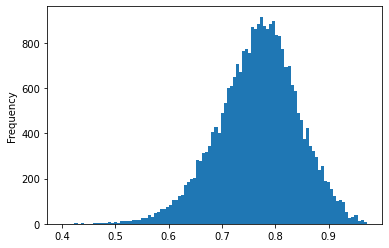

In [73]:
avg_neighbor_sim_df['avg_neighbor_sim'].plot.hist(bins=100)

In [89]:
avg_neighbor_sim_df[avg_neighbor_sim_df.VID==get_vid('Journal of Biomedical Research')]

,VID,avg_neighbor_sim
23079,165426342.0,0.774357


In [98]:
get_neighbor('The World Journal of Men\'s Health')

['University of Colorado Law Review',
 'The Henry James Review',
 'Contemporary Security Policy',
 'Esq-a Journal of The American Renaissance',
 'International Journal of Leadership in Education',
 'Qualitative Theory of Dynamical Systems',
 'Orbis',
 'The National Interest',
 'Intelligence & National Security',
 'The Journal of Intelligence History',
 'Canadian Journal of Film Studies-revue Canadienne D Etudes Cinematographiques',
 'The Strategic Review for Southern Africa',
 'Studies in American Fiction',
 'Middle East Quarterly',
 'Conflict Trends',
 'Vietnam journal of mathematics']

In [93]:
model.load_walks(2000, 2009)

2023-09-01 20:54:59 -- start loading walks...
2023-09-01 20:57:26 -- finish.


In [ ]:
focal_walks = []
vid = get_vid('The World Journal of Men\'s Health')
for walk in model.walks:
    if vid in walk:
        focal_walks.append(walk)

In [ ]:
focal_walks